<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20230414_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 평가

성능 평가 지표는 회귀냐 분류 모형이냐에 따라 다양한 종류 
>
* 회귀 : 실제값과 예측값의 오차 평균값에 기반
* 분류(이진/멀티) : 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적은지에 기반하지만 이러한 정확도만으로 판단하면 잘못할 수 있음

분류 평가 지표 : 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC

**01 정확도(Accuracy)**
>
정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
>
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않음.

* 아무런 학습을 하지 않고, 성별에 따라 타이타닉 생존자를 예측하는 단순한 Classifier 생성

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np
class MyDummyClassifier(BaseEstimator):
  # fit() 메서드는 아무것도 학습하지 않음.
  def fit(self,X,y=None):
    pass
  # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
  def predict(self,X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]) :
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    return pred

-> MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행

In [ ]:
from sklearn import preprocessing
# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
  return df

# 레이블 인코딩 수행.
def format_features(df):
  df['Cabin']= df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])

  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


-> 이렇게 단순한 알고리즘으로 예측해도 데이터 구성에 따라 정확도 결과가 78.77%로 높은 수치가 나올 수 있기 때문에 신중하게 정확도를 평가 지표로 사용해야 함.(특히 불균형한 레이블 값 분포에서 성능을 판단할 때 더 심함)

* MNIST 데이터 세트를 불균형한 데이터 세트로 만든 뒤, 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴봄.
> 
load_digits() api를 통해 mnist 데이터 세트를 제공, 레이블 값이 7이면 true, 아니면 false로 변환해 이진 분류 문제로 사용

불균형한 데이터 세트와 Dummy Classifier 생성

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X,y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)
  
  # 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
  digits = load_digits()

  # digits 번호가 7번이면 True이고 이를 astype(int)로 변환, 7번이 아니면 False이고 0으로 변환.
  y = (digits.target==7).astype(int)
  X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고 MyFakeClassifier를 이용해 예측, 평가 수행

In [ ]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (179,)
테스트 세트 레이블 0과 1의 분포도
0    110
1     69
Name: Survived, dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.615


-> 단순히 predict 결과를 np.zeros()로 모두 0으로 반환함에도 예측 정확도가 높은편이므로 말도 안 되는 결과
>
-> 불균형한 레이블 데이터 세트에서는 성능 수치로 사용되어서는 안 됨, 여러 분류 지표와 함께 적용해야 함.

**02 오차 행렬**

오차 행렬 : 이진 분류의 예측 오류가 얼마인지와 더불어 어떤 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
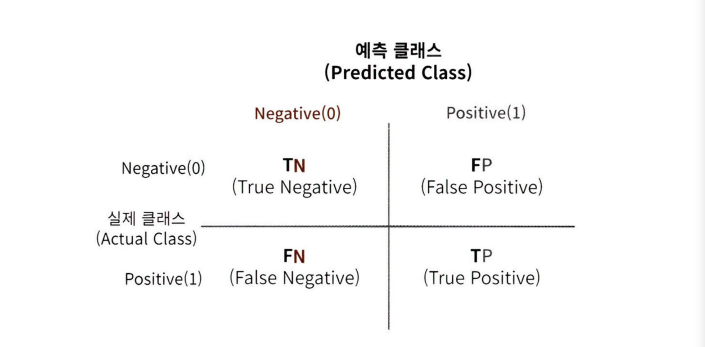

TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정 값(1), Negative 결정 값(0)의 결합에 따라 결정
>
* TN는 예측값을 N(0) 값으로 예측했고 실제 값 역시 N(0)
* FP는 예측값을 P(1)로 예측했는데 실제 값은 N(0)
* FN는 예측값을 N(0)으로 예측했는데 실제 값은 P(1)
* TP는 예측값을 P(1)로 예측했는데 실제 값 역시 P(1)

사이킷런에서 오차 행렬 구하는 방법 : confusion_matrix()
>
위에서 사용한 MyFakeClassifier의 예측 성능 지료를 오차 행렬로 표현

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[110,   0],
       [ 69,   0]])

이진분류의 TN,FP,FN,FP는 상단 도표와 동일한 위치, array에서 가져올 수 있음.
>
MyFakeClassifier는 load_digits()에서 target==7인지 아닌지에 따라 클래스를 이진 분류로 변경한 데이터 세트를 사용
>
-> 무조건 0으로 예측해 T가 된 결과 405건, FP는 P로 예측 건수가 없어 0, FN은 Positive인 건수 45건을 N으로 예측해 False가 된 45건, TP은 P를 예측한 건수가 없어 0건

TP,TN,FP,FN 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보 제공 -> 정확도, 정밀도, 재현율
>
정확도 : 실제값과 예측값이 얼마나 동일한지를 나타냄 -> (TN+TP) / (TN+FP+FN+TP)

이진 분류 모델의 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 P를 설정해 1을 부여, N로 0을 부여함.
> 
-> Positive의 데이터 건수가 매우 적기 때문에 데이터에 기반한 ML 알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생함
>
->Negative로 예측할 때 정확도가 높기 때문에 FN가 매우 작고 Positive로 예측하는 경우가 작기 때문에 FP도 매우 작아짐.
>
-> 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적 판단 오류를 일으키게 됨.


**03 정밀도와 재현율**

* Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
>
정밀도 : TP / (FP + TP)
>
재현율 : TP / (FN + TP)

1) 정밀도(양성 예측도) = 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 : precision_score()
>
-> 분모는 예측을 Positive로 한 모든 데이터 건수, 분자는 예측과 실제 값이 Positive로 일치한 데이터 건수


* 정밀도가 중요 지표인 경우: 스팸메일 여부를 판단하는 모델의 경우, 실제 positive인 스팸 메일을 negative인 일반 메일로 분류하는 것은 불편함 정도이지만, 실제 negative인 일반 메일을 positive인 스팸 메일로 분류하게 되면 메일을 받을 수 없어 업무에 차질이 생김.

2) 재현율(민감도) = 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 : recall_score()
>
-> 분모는 실제 값이 Positive인 모든 데이터 건수, 분자는 예측과 실제 값이 Positive로 일치한 데이터 건수

* 재현율이 중요 지표인 경우 : 
>
실제 positive인 암 환자를 negative로 잘못 판단할 경우 오류의 대가가 생명을 앗아갈 정도로 심각함.
>
실제 금융거래 사기인 positive 건을 negative로 잘못 판단하게 되면 회사에 미치는 손해가 크기 때문에 중요함.

-> 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용됨. -> 재현율과 정밀도가 모두 높은 수치를 얻으면 성능이 가장 좋은 것

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# confusion matrix, accuracy, precision, recall 평가 지표를 한 번에 호출
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test, pred) 
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:.4f},정밀도 : {1: .4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492,정밀도 :  0.7742, 재현율: 0.7869


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* 정밀도 / 재현율 트레이드 오프

분류하려는 업무의 특성상 정밀도/재현율이 특별히 강조돼야 할 경우, 분류의 결정 임곗값을 조정해 두 가지 수치를 높일 수 있음 but 둘은 상호보완적인 평가 지표이므로 한 쪽을 강제로 높으면 한 수치는 떨어짐.
>
사이킷런의 분류 알고리즘 : 예측 데이터가 특정 레이블에 속하는 지 계산하기 위해 먼저 개별 레이블 별로 결정확률을 구함 -> 예측 확률이 큰 레이블 값으로 예측 => 임계값을 정하면 이 기준 값보다 확률이 크면 positive, 작으면 negative로 결정
>
predict_proba() : 개별 클래서 별로 예측 확률을 반환하는 메서드, 학습이 완료된 classifier 객체에서 호출 가능 (predict 메서드와 유사하지만, 결과가 예측 클래스 값이 아닌 예측 확률)

In [ ]:
import numpy as np

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n',pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


predict 메서드는 predict_proba 메서드에 기반해 생성된 API인데, 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있음.
>
-> 이 로직을 코드로 구현해 사이킷런의 정밀도/재현율 트레이드오프 방식을 이해

먼저, 사이킷런의 Binarizer 클래스 이용법부터 알아봄

In [ ]:
from sklearn.preprocessing import Binarizer
X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


binarizer를 이용해 LogisticRegression 객체의 predict_proba() 메서드로 구한 각 클래스 예측 확률값인 pred_proba 객체 변수에 분류 결정 임곗값을 0.5로 지정한 binarizer 클래스를 적용해 최종 예측값 구함. + 최종 예측값에 대해 get_clf_eval() 함수도 적용

In [ ]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492,정밀도 :  0.7742, 재현율: 0.7869


-> predict로 구한 값과 정확히 일치

In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324,정밀도 :  0.7183, 재현율: 0.8361


-> 임곗값을 낮추어 재현율 값이 올라가고 정밀도가 떨어짐
>
-> 이유: 임계값을 낮추어 True 값이 많아지기 때문에 재현율 값이 높아짐, 정밀도 값은 낮아짐

임곗값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사(get_eval_by_threshold 함수 생성)

In [ ]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
  # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값 : ',custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값 :  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324,정밀도 :  0.7183, 재현율: 0.8361
임곗값 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492,정밀도 :  0.7656, 재현율: 0.8033
임곗값 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492,정밀도 :  0.7742, 재현율: 0.7869
임곗값 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659,정밀도 :  0.8364, 재현율: 0.7541
임곗값 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771,정밀도 :  0.8824, 재현율: 0.7377


-> 임곗값 변화에 따른 평가 지표 값 알아보는 코드
>
-> 사이킷런에서 제공하는 API : precision_recall_curve()

precision_recall_curve
>
입력 파라미터: y_true, positive 칼럼의 예측 확률 배열
>
반환 값 : 정밀도, 재현율

* 타이타닉 예측 모델의 임곗값 별 정밀도와 재현율 구하기

In [ ]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출.
thr_index = np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값 별 정밀도 : ',np.round(precisions[thr_index],3))
print('샘플 임계값 별 재현율 : ',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값 별 정밀도 :  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값 별 재현율 :  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


-> 임계값이 증가할수록 정밀도는 높아지지만 재현율 값은 낮아짐

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

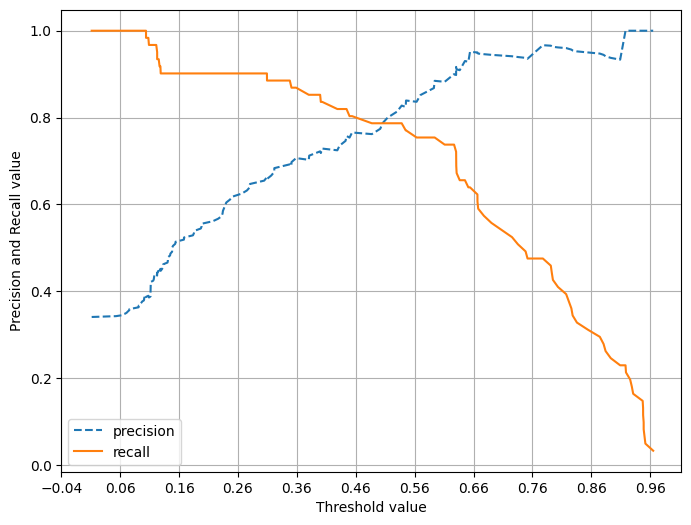

In [ ]:
def precision_recall_curve_plot(y_test,pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label ='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()
  
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

-> 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고, 정밀도 값이 극도로 낮아짐
>
-> 임곗값이 0.45 지점에서 재현율과 정밀도가 비슷해짐.

**정밀도와 재현율의 맹점**

Positive 예측의 임곗값을 변경함에 따라 정밀도, 재현율의 수치가 변경됨 -> 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 함.

* 정밀도가 100%가 되는 방법: 확실한 기준이 되는 경우만 Positive로 예측, 나머지는 모두 Negative로 예측

>
* 재현율이 100%가 되는 방법: 모든 환자를 Positive로 예측
>

-> 정밀도와 재현율 성능 수치도 어느 한 쪽만 참고하면 극단적 수치 조작이 가능하기 때문에 둘 중 하나만 강조하는 상황이 되어서는 안 됨.

**04 F1 스코어**

F1 스코어 : 정밀도와 재현율을 결합한 지표, 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 높은 값을 가짐
>
F1 = 2*precision*recall/(precision + recall)
>
f1_score() API 제공

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


타이타닉 생존자 예측에서 임곗값을 변화시키면서 평가 지표 구하기 -> get_clf_eval() 함수에 f1스코어를 구하는 로직 추가, get_eval_by_threshold() 함수를 이용해 임곗값 0.4~0.6 별로 정확도, 정밀도, 재현율, f1스코어 구하기

In [ ]:
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  # F1 스코어 추가
  f1 = f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy,precision,recall,f1))

thresholds = [0.4,0.45,0.5, 0.55,0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값 :  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


F1 스코어는 임곗값이 0.6일 때 가장 좋은 값을 보여주지만, 재현율이 크게 감소

**05 ROC 곡선과 AUC**

ROC 곡선은 FPR이 변할 때 TPR(재현율)이 어떻게 변하는지를 나타내는 곡선

민감도(TPR) : 양성이 정확히 예측돼야 하는 수준 
>
특이도(TNR) : 음성이 정확히 예측돼야 하는 수준
>
-> FPR = 1-TNR(특이도)

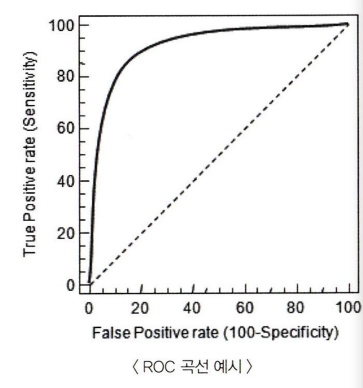

가운데 직선에 가까울수록 성능이 떨어짐, 멀어질수록 성능이 뛰어남
>
ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값 구함.
>
임곗값을 1로 지정하면 FP 값이 0이 되므로 FPR은 0이 됨, 임곗값을 0으로 지정하면 TN가 0이 되어 FPR은 1이 됨.

ROC 곡선을 구하기 위해서 roc_curve() API 사용
>
입력 파라미터 : y_true, y_score
>
반환 값 : fpr, tpr, thresholds 값 (array 형태)

* 타이타닉 생존자 예측 모델의 fpr, tpr, 임곗값 구하기

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1,thresholds.shape[0],5)

print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


-> roc_curve 결과, 임곗값이 1에서 가까운 값에서 점점 작아지면서 FPR이 커짐, TPR은 가파르게 커짐.

* FPR의 변화에 따른 TPR의 변화 시각화

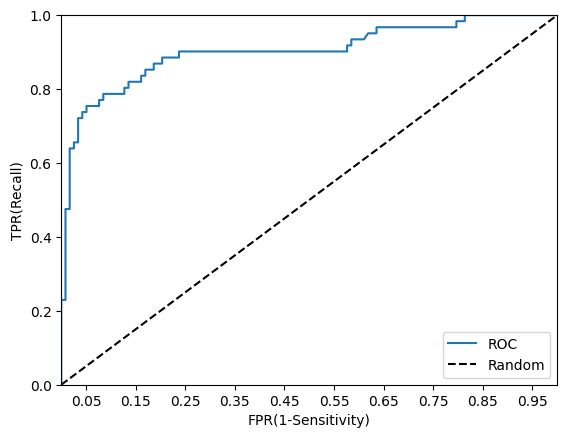

In [ ]:
def roc_curve_plot(y_test,pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음.
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k--',label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test,pred_proba[:,1])

-> ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용, 분류의 성능 지표는 ROC 곡선 면적에 기반한 AUC 값으로 결정(1에 가까울수록 좋음)
>
-> FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print('정확도 : ',np.round(accuracy_score(y_target,preds),4))
print('정밀도 : ',np.round(precision_score(y_target,preds),4))
print('재현율 : ',np.round(recall_score(y_target,preds),4))

get_clf_eval() 함수에 roc_auc_score()를 이용해 ROC AUC 값 측정

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
  # ROC - AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC - AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},/ F1: {3:.4f},AUC:{4:4f}'.format(accuracy, precision, recall, f1, roc_auc))